In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
# PLACE ALL IMPORTS HERE
import pandas as pd
import sys
from google.colab import drive
import sklearn
import sklearn.impute, sklearn.pipeline
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from scipy.stats import uniform, randint


from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Initialization

In [ ]:
# MOUNT YOUR GOOGLE DRIVE 
# (It only mounts to your private Virtual Machine, it doesn't expose your drive to anyone else)
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# LOAD THE FILE
df = pd.read_csv("/content/drive/My Drive/Data Mining Project - Share/Data/combined.csv")
# Converting the column to DateTime format
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df = df.set_index('Date')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,39,42,44,45,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,2,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,4,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,5,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2020-01-01,2020,1,1,6,d,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,0,.,0.0,0.0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


In [ ]:
# Convert to numerical values
for col in df.columns:
  if (col != "freq"):
    df[col] = pd.to_numeric(df[col], errors="coerce")

display(df.head())

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,2,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,4,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,5,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,6,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

In [ ]:
display(df)

print("First valid Spend ACF:",df["spend_acf"].first_valid_index())
print("First valid Test:", df["test_count"].first_valid_index())
print("First valid bg_posts:", df["bg_posts"].first_valid_index())

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020,1,1,1,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,2,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,4,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,5,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,2020,1,1,6,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-05,2020,11,5,51,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187202,3688,2733990.0,2193.0,43.2,32031.0,0.0726,15.1,0.087,230.0,1288.0,7.43,19627.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,2020,11,5,53,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118459,2542,2519494.0,1556.0,33.4,33086.0,0.0562,14.5,0.148,255.0,1102.0,11.30,19452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-05,2020,11,5,54,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26547,480,817092.0,1481.0,26.8,45593.0,0.0515,24.6,0.295,458.0,440.0,5.29

First valid Spend ACF: 2020-01-13 00:00:00
First valid Test: 2020-01-22 00:00:00
First valid bg_posts: 2020-01-10 00:00:00


# Preprocessing

## Filtering

In [ ]:
# DO PREPROCESSING

# Drop January and November
df_simple = df[df["month"].gt(1) & df["month"].lt(11)].copy()
df_simple.head()

,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,spend_retail_w_grocery,spend_retail_no_grocery,provisional,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,case_count,death_count,test_count,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,2020,2,1,1,d,0.010200,-0.10200,-0.0261,-0.000159,-0.00956,0.008790,-0.00416,-0.0293,-0.0258,-0.02700,-0.00678,-0.00478,0.0,-0.0211,-0.02430,-0.00398,-0.0258,-0.00287,0.012000,0.00773,0.000303,0.03300,0.00720,0.005810,0.000862,0.01300,-0.00192,-0.00402,-0.00257,0.00757,0.00314,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,2170.0,0.0968,17284.0,0.771,0.0,0.0,0.0,0.0,0.0,0.0,2170.0,17284.0,0.0968,0.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,2,d,0.140000,-0.14700,0.0265,0.038900,0.06000,-0.265000,0.10200,0.0169,NaN,0.07820,0.08580,0.09720,0.0,-0.0889,-0.03990,-0.07910,-0.4130,-0.03180,-0.023500,-0.04630,-0.056000,-0.00588,-0.01670,0.000821,-0.034700,0.00512,0.00345,-0.03080,-0.00493,0.02620,-0.01040,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,1122.0,0.3230,9579.0,2.750,0.0,0.0,0.0,0.0,0.0,0.0,1122.0,9579.0,0.3230,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,4,d,0.014300,0.03390,0.0109,0.049500,0.04140,0.002390,-0.02570,0.0292,0.0257,-0.00371,0.03740,0.03510,0.0,-0.0333,-0.01110,0.05630,-0.0772,-0.04070,-0.005150,-0.00581,-0.003890,-0.00931,-0.00540,0.009640,0.001150,0.01310,0.01100,0.00263,0.00712,0.00956,0.01060,1,0,NaN,0.01370,0.0,NaN,NaN,0.001960,0.0,NaN,0.143,0.0,NaN,3807.0,0.1070,18854.0,0.531,0.0,0.0,0.0,0.0,0.0,0.0,3807.0,18854.0,0.1070,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,5,d,-0.000614,0.05180,0.0321,0.082300,0.03120,0.000837,-0.02560,0.1830,0.0527,0.01080,0.03920,0.04580,0.0,-0.0488,0.00923,-0.08170,-0.0260,0.00344,-0.000437,-0.00251,-0.033500,-0.00814,0.00579,0.005490,0.008750,0.00828,NaN,-0.00762,0.01320,NaN,0.03010,0,0,NaN,0.00000,0.0,NaN,NaN,0.000000,0.0,NaN,0.000,0.0,NaN,1837.0,0.1350,13210.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,1837.0,13210.0,0.1350,0.969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,2020,2,1,6,d,0.008510,0.00176,-0.0107,0.017200,0.01340,-0.023700,-0.00323,-0.0135,-0.0109,-0.00532,0.00249,-0.00126,0.0,-0.0342,-0.01510,-0.05200,-0.0755,-0.02620,-0.007420,-0.00757,-0.018300,-0.00621,-0.00631,0.011000,-0.012600,0.01610,0.01030,0.00511,0.00899,0.01610,0.01490,3,0,NaN,0.00759,0.0,NaN,NaN,0.000723,0.0,NaN,0.286,0.0,NaN,43458.0,0.2240,388341.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,43458.0,388341.0,0.2240,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Imputing/Filling

Stategy: Don't use Simple Imputer, which takes the mean/median/mode/etc. across all records in a feature. This would lose the time sensitive data. Here we are using "method = time" for imputation. Feel free to change it to linear if you want or anything else and test it

In [ ]:

# First fill COVID data
covid_ids = ["death", "case", "test", "positives"]
# If March or earlier, fill NAs with zero
for col in df_simple.columns:
  for covid_id in covid_ids:
    if covid_id in col:
      df_simple.loc[df_simple["month"]<=3, col] = df_simple.loc[df_simple["month"]<=3, col].fillna(0, inplace=False)
      # Also force all to be >= 0
      df_simple.loc[:, col] = df_simple.loc[:, col].clip(lower=0, inplace=False)
      #df_simple.loc[col, df_simple[col].isna()] = 0


#df_simple = df_simple.drop(['year','month','day','freq'],axis=1)
## Impute the DATA
count = df_simple.isna().sum()
print(count)
df_simple = df_simple.interpolate(method = 'time')

#df_slinear = df_simple.assign(InterpolateSLinear=df_simple.target.interpolate(method='slinear'))
count_2 = df_simple.isna().sum()
print(count_2)

year                     0
month                    0
day                      0
statefips                0
freq                     0
                     ...  
bg_posts_jz2         11985
bg_posts_jz3         11985
bg_posts_jzgrp345    11985
bg_posts_jz4         11985
bg_posts_jz5         11985
Length: 76, dtype: int64
year                   0
month                  0
day                    0
statefips              0
freq                   0
                    ... 
bg_posts_jz2         306
bg_posts_jz3         306
bg_posts_jzgrp345    306
bg_posts_jz4         306
bg_posts_jz5         306
Length: 76, dtype: int64


In [ ]:
## This is just a function used to get the covid delays, 
## just pass to it a delay vector and it can delay the covid data by any element in the vector
def df_derived_by_shift(df,lag=0):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in lag:
        for x in list(df.columns):
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 0
        for c in columns:
            dfn[c] = df[k].shift(periods=lag[i]*51) ## this is because we want to shift all the 51 states
            i = i+1
        df = pd.concat([df, dfn], axis=1)
    return df

In [ ]:
# Drop cumulative COVID data (better to use rates/new counts)
covid_columns = ["case_rate", 	
                 "death_rate", 	
                 "test_rate", 	
                 "new_positives_rate",
                 "new_case_rate", 	
                 "new_death_rate", 	
                 "new_test_rate", 	
                 "new_case_count", 	
                 "new_death_count", 	
                 "new_test_count"]

states = ["statefips"]  

spending_columns = ["spend_acf",	"spend_aer",	"spend_all",	"spend_apg",	"spend_grf",	"spend_hcs","spend_tws",
                    "spend_all_inchigh",	"spend_all_inclow",	"spend_all_incmiddle"]

revenues_columns = ["revenue_all",	"revenue_ss40",	"revenue_ss60",	"revenue_ss65",
                    "revenue_ss70",	"merchants_all",	"merchants_ss40",	"merchants_ss60",	"merchants_ss65",	"merchants_ss70"]

employment_columns = ["emp_combined",	"emp_combined_inclow",	"emp_combined_incmiddle", "emp_combined_inchigh",	"emp_combined_ss40",	"emp_combined_ss60",
                      "emp_combined_ss65",	"emp_combined_ss70","initclaims_count_regular",	"initclaims_rate_regular",	"contclaims_count_regular",	
                      "contclaims_rate_regular",	"initclaims_count_pua",	"contclaims_count_pua",	"contclaims_count_peuc",	"initclaims_rate_pua",
                      "contclaims_rate_pua",	"contclaims_rate_peuc","initclaims_count_combined",	"contclaims_count_combined",	"initclaims_rate_combined",
                      "contclaims_rate_combined",	"bg_posts","bg_posts_ss30",	"bg_posts_ss55",	"bg_posts_ss60",	"bg_posts_ss65",	"bg_posts_ss70",
                      "bg_posts_jz1",	"bg_posts_jzgrp12","bg_posts_jz2","bg_posts_jz3",	"bg_posts_jzgrp345",	"bg_posts_jz4",	"bg_posts_jz5"]


df_covid = df_simple.filter(covid_columns, axis=1)
df_states = df_simple.filter(states, axis=1)
df_spending = df_simple.filter(spending_columns, axis=1)
df_revenues = df_simple.filter(revenues_columns, axis=1)
df_employment = df_simple.filter(employment_columns, axis=1)

econ_frames = [df_spending, df_revenues,df_employment]
df_econ = pd.concat(econ_frames,axis=1)

display(df_econ.head())
display(df_covid.head())

,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.010200,-0.10200,-0.0261,-0.000159,-0.00956,0.008790,-0.00416,-0.0293,-0.0258,-0.02700,-0.0211,-0.02430,-0.00398,-0.0258,-0.00287,0.012000,0.00773,0.000303,0.03300,0.00720,0.005810,0.000862,0.01300,-0.00192,-0.00402,-0.00257,0.00757,0.00314,2170.0,0.0968,17284.0,0.771,0.0,0.0,0.0,0.0,0.0,0.0,2170.0,17284.0,0.0968,0.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.140000,-0.14700,0.0265,0.038900,0.06000,-0.265000,0.10200,0.0169,0.0498,0.07820,-0.0889,-0.03990,-0.07910,-0.4130,-0.03180,-0.023500,-0.04630,-0.056000,-0.00588,-0.01670,0.000821,-0.034700,0.00512,0.00345,-0.03080,-0.00493,0.02620,-0.01040,1122.0,0.3230,9579.0,2.750,0.0,0.0,0.0,0.0,0.0,0.0,1122.0,9579.0,0.3230,2.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.014300,0.03390,0.0109,0.049500,0.04140,0.002390,-0.02570,0.0292,0.0257,-0.00371,-0.0333,-0.01110,0.05630,-0.0772,-0.04070,-0.005150,-0.00581,-0.003890,-0.00931,-0.00540,0.009640,0.001150,0.01310,0.01100,0.00263,0.00712,0.00956,0.01060,3807.0,0.1070,18854.0,0.531,0.0,0.0,0.0,0.0,0.0,0.0,3807.0,18854.0,0.1070,0.531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,-0.000614,0.05180,0.0321,0.082300,0.03120,0.000837,-0.02560,0.1830,0.0527,0.01080,-0.0488,0.00923,-0.08170,-0.0260,0.00344,-0.000437,-0.00251,-0.033500,-0.00814,0.00579,0.005490,0.008750,0.00828,-0.00377,-0.00762,0.01320,0.00756,0.03010,1837.0,0.1350,13210.0,0.969,0.0,0.0,0.0,0.0,0.0,0.0,1837.0,13210.0,0.1350,0.969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.008510,0.00176,-0.0107,0.017200,0.01340,-0.023700,-0.00323,-0.0135,-0.0109,-0.00532,-0.0342,-0.01510,-0.05200,-0.0755,-0.02620,-0.007420,-0.00757,-0.018300,-0.00621,-0.00631,0.011000,-0.012600,0.01610,0.01030,0.00511,0.00899,0.01610,0.01490,43458.0,0.2240,388341.0,2.000,0.0,0.0,0.0,0.0,0.0,0.0,43458.0,388341.0,0.2240,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count
Date,,,,,,,,,,
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.01370,0.0,0.0,0.0,0.001960,0.0,0.0,0.143,0.0,0.0
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0
2020-02-01,0.00759,0.0,0.0,0.0,0.000723,0.0,0.0,0.286,0.0,0.0


In [ ]:
## This is where we use the previous function to delay the covid data/ Econ data which are already imputed
## If you also want to use the econ delayed data as an input, comment out the commented commands
delay_covid = [7,14,21]
delay_econ = [7,14,21]

df_covid = df_derived_by_shift(df_covid, delay_covid)
df_econ = df_derived_by_shift(df_econ, delay_econ)
display(df_covid.head())

,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,case_rate_7,case_rate_14,case_rate_21,death_rate_7,death_rate_14,death_rate_21,test_rate_7,test_rate_14,test_rate_21,new_positives_rate_7,new_positives_rate_14,new_positives_rate_21,new_case_rate_7,new_case_rate_14,new_case_rate_21,new_death_rate_7,new_death_rate_14,new_death_rate_21,new_test_rate_7,new_test_rate_14,new_test_rate_21,new_case_count_7,new_case_count_14,new_case_count_21,new_death_count_7,new_death_count_14,new_death_count_21,new_test_count_7,new_test_count_14,new_test_count_21
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.01370,0.0,0.0,0.0,0.001960,0.0,0.0,0.143,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.00759,0.0,0.0,0.0,0.000723,0.0,0.0,0.286,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_covid.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [ ]:
## As you can see now we have NANs that arises from 2 things:
## 1- The imputation method won't fill all of them
## 2- Shifting the data will introduce NAN entries
## Let's remove all of the NAN entries now. I am appending the data again because we need all the data to have the same index
frames = [df_states, df_covid, df_econ]
df_new = pd.concat(frames,axis=1)
df_new = df_new.dropna()
display(df_new.head())

,statefips,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,case_rate_7,case_rate_14,case_rate_21,death_rate_7,death_rate_14,death_rate_21,test_rate_7,test_rate_14,test_rate_21,new_positives_rate_7,new_positives_rate_14,new_positives_rate_21,new_case_rate_7,new_case_rate_14,new_case_rate_21,new_death_rate_7,new_death_rate_14,new_death_rate_21,new_test_rate_7,new_test_rate_14,new_test_rate_21,new_case_count_7,new_case_count_14,new_case_count_21,new_death_count_7,new_death_count_14,new_death_count_21,new_test_count_7,new_test_count_14,...,contclaims_rate_combined_21,bg_posts_7,bg_posts_14,bg_posts_21,bg_posts_ss30_7,bg_posts_ss30_14,bg_posts_ss30_21,bg_posts_ss55_7,bg_posts_ss55_14,bg_posts_ss55_21,bg_posts_ss60_7,bg_posts_ss60_14,bg_posts_ss60_21,bg_posts_ss65_7,bg_posts_ss65_14,bg_posts_ss65_21,bg_posts_ss70_7,bg_posts_ss70_14,bg_posts_ss70_21,bg_posts_jz1_7,bg_posts_jz1_14,bg_posts_jz1_21,bg_posts_jzgrp12_7,bg_posts_jzgrp12_14,bg_posts_jzgrp12_21,bg_posts_jz2_7,bg_posts_jz2_14,bg_posts_jz2_21,bg_posts_jz3_7,bg_posts_jz3_14,bg_posts_jz3_21,bg_posts_jzgrp345_7,bg_posts_jzgrp345_14,bg_posts_jzgrp345_21,bg_posts_jz4_7,bg_posts_jz4_14,bg_posts_jz4_21,bg_posts_jz5_7,bg_posts_jz5_14,bg_posts_jz5_21
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.21600,0.111,0.4430,0.41100,0.3730,0.3490,0.2270,0.0663,0.4810,0.3250,0.2010,0.539,0.1340,0.00295,0.1990,0.127,0.2810,0.8150,0.240,0.1330,0.8210,0.1820,0.0964,0.740,0.1770,0.0938,0.757,0.2550,0.0755,0.31500,0.23100,0.1140,0.4060,0.243000,0.2200,0.393,0.13900,-0.0539,0.41600
2020-02-28,2,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.11000,0.105,0.0160,-0.11400,0.0539,-0.0659,-0.2070,0.2030,0.2790,-0.1420,0.4620,0.252,-0.1140,0.00752,-0.0476,-0.315,0.1020,0.0648,-0.145,-0.0520,-0.0520,-0.0517,0.2510,0.120,-0.0432,0.2790,0.136,-0.0901,0.0743,-0.00234,-0.14200,0.0492,-0.0212,-0.124000,0.1750,0.125,-0.26400,-0.1580,-0.24300
2020-02-28,4,0.0137,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0137,0.0137,0.0137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.04250,0.183,-0.1380,-0.00593,0.1860,-0.1620,-0.0433,0.1870,-0.0955,-0.1780,0.0447,-0.143,0.0971,0.26100,-0.0725,-0.128,0.1340,-0.1670,-0.102,0.1390,-0.0796,-0.1200,0.1930,-0.138,-0.1220,0.1990,-0.144,0.0772,0.1940,-0.13000,0.00334,0.1730,-0.1450,-0.053900,0.1510,-0.147,-0.00699,0.1880,-0.17600
2020-02-28,5,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.06890,-0.127,-0.0161,0.15600,0.3440,0.0452,0.0294,-0.1430,-0.0685,0.0979,-0.0226,0.332,0.0351,-0.12800,0.2280,-0.359,0.2540,-0.4190,-0.419,0.2280,-0.3610,-0.2450,-0.1900,-0.227,-0.2340,-0.2170,-0.219,0.1320,-0.0791,0.21900,0.04540,-0.0788,0.1530,0.046300,0.0556,0.158,-0.14800,-0.3000,-0.00385
2020-02-28,6,0.0683,0.0,0.0,0.0,0.00651,0.0,0.0,2.57,0.0,0.0,0.0228,0.0177,0.0152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000723,0.000362,0.00108,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.143,0.429,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.00542,0.215,-0.1150,0.08020,0.3330,-0.1540,-0.0756,0.1670,-0.0475,-0.1850,0.0773,-0.175,0.0828,0.26400,-0.0954,-0.124,0.0501,-0.0894,-0.154,-0.0138,-0.1110,-0.0449,0.1480,-0.101,-0.0351,0.1630,-0.101,0.0513,0.2560,-0.11200,0.02670,0.2390,-0.1230,-0.000304,0.2100,-0.137,0.06640,0.3020,-0.10100


In [ ]:
frames2 = [df_states, df_covid, df_econ]
df_covid_w_state = pd.concat(frames2,axis=1)
df_covid_w_state = df_covid_w_state.dropna()
display(df_covid_w_state.head())

non_covid2 = states + spending_columns +  revenues_columns + employment_columns


,statefips,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,case_rate_7,case_rate_14,case_rate_21,death_rate_7,death_rate_14,death_rate_21,test_rate_7,test_rate_14,test_rate_21,new_positives_rate_7,new_positives_rate_14,new_positives_rate_21,new_case_rate_7,new_case_rate_14,new_case_rate_21,new_death_rate_7,new_death_rate_14,new_death_rate_21,new_test_rate_7,new_test_rate_14,new_test_rate_21,new_case_count_7,new_case_count_14,new_case_count_21,new_death_count_7,new_death_count_14,new_death_count_21,new_test_count_7,new_test_count_14,...,contclaims_rate_combined_21,bg_posts_7,bg_posts_14,bg_posts_21,bg_posts_ss30_7,bg_posts_ss30_14,bg_posts_ss30_21,bg_posts_ss55_7,bg_posts_ss55_14,bg_posts_ss55_21,bg_posts_ss60_7,bg_posts_ss60_14,bg_posts_ss60_21,bg_posts_ss65_7,bg_posts_ss65_14,bg_posts_ss65_21,bg_posts_ss70_7,bg_posts_ss70_14,bg_posts_ss70_21,bg_posts_jz1_7,bg_posts_jz1_14,bg_posts_jz1_21,bg_posts_jzgrp12_7,bg_posts_jzgrp12_14,bg_posts_jzgrp12_21,bg_posts_jz2_7,bg_posts_jz2_14,bg_posts_jz2_21,bg_posts_jz3_7,bg_posts_jz3_14,bg_posts_jz3_21,bg_posts_jzgrp345_7,bg_posts_jzgrp345_14,bg_posts_jzgrp345_21,bg_posts_jz4_7,bg_posts_jz4_14,bg_posts_jz4_21,bg_posts_jz5_7,bg_posts_jz5_14,bg_posts_jz5_21
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.21600,0.111,0.4430,0.41100,0.3730,0.3490,0.2270,0.0663,0.4810,0.3250,0.2010,0.539,0.1340,0.00295,0.1990,0.127,0.2810,0.8150,0.240,0.1330,0.8210,0.1820,0.0964,0.740,0.1770,0.0938,0.757,0.2550,0.0755,0.31500,0.23100,0.1140,0.4060,0.243000,0.2200,0.393,0.13900,-0.0539,0.41600
2020-02-28,2,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.11000,0.105,0.0160,-0.11400,0.0539,-0.0659,-0.2070,0.2030,0.2790,-0.1420,0.4620,0.252,-0.1140,0.00752,-0.0476,-0.315,0.1020,0.0648,-0.145,-0.0520,-0.0520,-0.0517,0.2510,0.120,-0.0432,0.2790,0.136,-0.0901,0.0743,-0.00234,-0.14200,0.0492,-0.0212,-0.124000,0.1750,0.125,-0.26400,-0.1580,-0.24300
2020-02-28,4,0.0137,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0137,0.0137,0.0137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.04250,0.183,-0.1380,-0.00593,0.1860,-0.1620,-0.0433,0.1870,-0.0955,-0.1780,0.0447,-0.143,0.0971,0.26100,-0.0725,-0.128,0.1340,-0.1670,-0.102,0.1390,-0.0796,-0.1200,0.1930,-0.138,-0.1220,0.1990,-0.144,0.0772,0.1940,-0.13000,0.00334,0.1730,-0.1450,-0.053900,0.1510,-0.147,-0.00699,0.1880,-0.17600
2020-02-28,5,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.06890,-0.127,-0.0161,0.15600,0.3440,0.0452,0.0294,-0.1430,-0.0685,0.0979,-0.0226,0.332,0.0351,-0.12800,0.2280,-0.359,0.2540,-0.4190,-0.419,0.2280,-0.3610,-0.2450,-0.1900,-0.227,-0.2340,-0.2170,-0.219,0.1320,-0.0791,0.21900,0.04540,-0.0788,0.1530,0.046300,0.0556,0.158,-0.14800,-0.3000,-0.00385
2020-02-28,6,0.0683,0.0,0.0,0.0,0.00651,0.0,0.0,2.57,0.0,0.0,0.0228,0.0177,0.0152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000723,0.000362,0.00108,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.143,0.429,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.00542,0.215,-0.1150,0.08020,0.3330,-0.1540,-0.0756,0.1670,-0.0475,-0.1850,0.0773,-0.175,0.0828,0.26400,-0.0954,-0.124,0.0501,-0.0894,-0.154,-0.0138,-0.1110,-0.0449,0.1480,-0.101,-0.0351,0.1630,-0.101,0.0513,0.2560,-0.11200,0.02670,0.2390,-0.1230,-0.000304,0.2100,-0.137,0.06640,0.3020,-0.10100


In [ ]:
## Save all the preprocessed data in drive
non_covid = states + spending_columns +  revenues_columns + employment_columns

df_states = df_new.filter(states, axis=1)
df_spending = df_new.filter(spending_columns, axis=1)
df_revenues = df_new.filter(revenues_columns, axis=1)
df_employment = df_new.filter(employment_columns, axis=1)

df_covid = df_new.drop(non_covid, axis=1)


econ_frames = [df_spending, df_revenues,df_employment]
df_econ = pd.concat(econ_frames,axis=1)

display(df_covid.head())
display(df_econ.head())

,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,case_rate_7,case_rate_14,case_rate_21,death_rate_7,death_rate_14,death_rate_21,test_rate_7,test_rate_14,test_rate_21,new_positives_rate_7,new_positives_rate_14,new_positives_rate_21,new_case_rate_7,new_case_rate_14,new_case_rate_21,new_death_rate_7,new_death_rate_14,new_death_rate_21,new_test_rate_7,new_test_rate_14,new_test_rate_21,new_case_count_7,new_case_count_14,new_case_count_21,new_death_count_7,new_death_count_14,new_death_count_21,new_test_count_7,new_test_count_14,new_test_count_21,...,contclaims_rate_combined_21,bg_posts_7,bg_posts_14,bg_posts_21,bg_posts_ss30_7,bg_posts_ss30_14,bg_posts_ss30_21,bg_posts_ss55_7,bg_posts_ss55_14,bg_posts_ss55_21,bg_posts_ss60_7,bg_posts_ss60_14,bg_posts_ss60_21,bg_posts_ss65_7,bg_posts_ss65_14,bg_posts_ss65_21,bg_posts_ss70_7,bg_posts_ss70_14,bg_posts_ss70_21,bg_posts_jz1_7,bg_posts_jz1_14,bg_posts_jz1_21,bg_posts_jzgrp12_7,bg_posts_jzgrp12_14,bg_posts_jzgrp12_21,bg_posts_jz2_7,bg_posts_jz2_14,bg_posts_jz2_21,bg_posts_jz3_7,bg_posts_jz3_14,bg_posts_jz3_21,bg_posts_jzgrp345_7,bg_posts_jzgrp345_14,bg_posts_jzgrp345_21,bg_posts_jz4_7,bg_posts_jz4_14,bg_posts_jz4_21,bg_posts_jz5_7,bg_posts_jz5_14,bg_posts_jz5_21
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.21600,0.111,0.4430,0.41100,0.3730,0.3490,0.2270,0.0663,0.4810,0.3250,0.2010,0.539,0.1340,0.00295,0.1990,0.127,0.2810,0.8150,0.240,0.1330,0.8210,0.1820,0.0964,0.740,0.1770,0.0938,0.757,0.2550,0.0755,0.31500,0.23100,0.1140,0.4060,0.243000,0.2200,0.393,0.13900,-0.0539,0.41600
2020-02-28,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.11000,0.105,0.0160,-0.11400,0.0539,-0.0659,-0.2070,0.2030,0.2790,-0.1420,0.4620,0.252,-0.1140,0.00752,-0.0476,-0.315,0.1020,0.0648,-0.145,-0.0520,-0.0520,-0.0517,0.2510,0.120,-0.0432,0.2790,0.136,-0.0901,0.0743,-0.00234,-0.14200,0.0492,-0.0212,-0.124000,0.1750,0.125,-0.26400,-0.1580,-0.24300
2020-02-28,0.0137,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0137,0.0137,0.0137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.04250,0.183,-0.1380,-0.00593,0.1860,-0.1620,-0.0433,0.1870,-0.0955,-0.1780,0.0447,-0.143,0.0971,0.26100,-0.0725,-0.128,0.1340,-0.1670,-0.102,0.1390,-0.0796,-0.1200,0.1930,-0.138,-0.1220,0.1990,-0.144,0.0772,0.1940,-0.13000,0.00334,0.1730,-0.1450,-0.053900,0.1510,-0.147,-0.00699,0.1880,-0.17600
2020-02-28,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.06890,-0.127,-0.0161,0.15600,0.3440,0.0452,0.0294,-0.1430,-0.0685,0.0979,-0.0226,0.332,0.0351,-0.12800,0.2280,-0.359,0.2540,-0.4190,-0.419,0.2280,-0.3610,-0.2450,-0.1900,-0.227,-0.2340,-0.2170,-0.219,0.1320,-0.0791,0.21900,0.04540,-0.0788,0.1530,0.046300,0.0556,0.158,-0.14800,-0.3000,-0.00385
2020-02-28,0.0683,0.0,0.0,0.0,0.00651,0.0,0.0,2.57,0.0,0.0,0.0228,0.0177,0.0152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000723,0.000362,0.00108,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.143,0.429,0.0,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.00542,0.215,-0.1150,0.08020,0.3330,-0.1540,-0.0756,0.1670,-0.0475,-0.1850,0.0773,-0.175,0.0828,0.26400,-0.0954,-0.124,0.0501,-0.0894,-0.154,-0.0138,-0.1110,-0.0449,0.1480,-0.101,-0.0351,0.1630,-0.101,0.0513,0.2560,-0.11200,0.02670,0.2390,-0.1230,-0.000304,0.2100,-0.137,0.06640,0.3020,-0.10100


,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,-0.05530,-0.0924,-0.05510,-0.14900,0.02370,-0.0354,-0.1300,0.00510,-0.053800,-0.07380,-0.0152,-0.054300,0.00795,0.00971,-0.02280,-0.0574,-0.0608,-0.0527,-0.0531,-0.0706,0.01140,-0.01340,0.0250,0.0229,0.00703,-0.00955,0.0242,-0.00257,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.0255,0.04910,0.1180,0.0955,0.134,-0.1810,-0.2600,-0.10000,-0.088800,0.156,0.103,0.0293,0.1460
2020-02-28,-0.03700,-0.1770,-0.03650,0.05240,0.11700,-0.0630,-0.0271,-0.04610,-0.056800,0.00102,-0.0578,-0.000793,-0.10100,0.06260,-0.08590,-0.0686,-0.1040,-0.1550,-0.0618,-0.0681,-0.01390,-0.10400,-0.0205,0.0179,-0.07540,-0.04310,0.0103,-0.01580,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.1900,0.07780,0.0832,-0.0284,0.288,0.1850,0.2250,0.16700,0.161000,0.334,0.194,0.0977,0.0528
2020-02-28,-0.04290,-0.1460,0.00954,0.01030,0.07640,0.0167,-0.0943,0.00408,-0.000566,0.01560,0.0151,0.100000,-0.09010,0.05660,-0.01320,-0.0151,0.0233,-0.0238,-0.0487,-0.0178,0.02250,-0.00153,0.0269,0.0396,0.01980,0.00731,0.0201,0.03560,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.0818,-0.00839,0.1410,-0.0915,0.283,0.0987,0.0491,0.00533,0.000909,0.193,0.130,0.0375,0.2660
2020-02-28,0.01020,-0.1520,0.00824,-0.02680,-0.00957,0.0879,-0.0645,0.09710,-0.007310,0.01640,0.0247,0.046700,0.03360,-0.00219,-0.03450,-0.0202,-0.0152,-0.0343,-0.0216,-0.0294,0.00739,-0.00892,0.0226,0.0160,-0.00685,0.02180,0.0994,0.04270,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,-0.0136,0.36300,0.0568,-0.1530,0.165,-0.2480,-0.3200,-0.28700,-0.284000,0.341,0.181,0.0603,0.0250
2020-02-28,-0.00761,-0.0953,-0.00987,0.00387,0.07580,-0.0242,-0.1060,-0.01300,0.001920,-0.00595,0.0121,0.020900,-0.02170,-0.01350,0.00662,-0.0276,-0.0349,-0.0295,-0.0281,-0.0289,0.02570,-0.03030,0.0337,0.0323,0.01040,0.01730,0.0333,0.04110,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.1020,0.11800,0.0714,-0.1850,0.235,0.0854,-0.0226,0.02770,0.032200,0.152,0.126,0.0518,0.3260


In [ ]:
df_states.to_csv('df_states.csv')
!cp df_states.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_covid.to_csv('df_covid.csv')
!cp df_covid.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_spending.to_csv('df_spending.csv')
!cp df_spending.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_revenues.to_csv('df_revenues.csv')
!cp df_revenues.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_employment.to_csv('df_employment.csv')
!cp df_employment.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_econ.to_csv('df_econ.csv')
!cp df_econ.csv "/content/drive/My Drive/Data Mining Project - Share/Data"


In [ ]:
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
new_frames_covid = [df_states,df_covid]
new_frames_econ = [df_states,df_econ]

df_covid_new = pd.concat(new_frames_covid,axis=1)
df_econ_new = pd.concat(new_frames_econ,axis=1)

display(df_covid_new.head())
display(df_econ_new.head())

,statefips,case_rate,death_rate,test_rate,new_positives_rate,new_case_rate,new_death_rate,new_test_rate,new_case_count,new_death_count,new_test_count,case_rate_7,case_rate_14,case_rate_21,death_rate_7,death_rate_14,death_rate_21,test_rate_7,test_rate_14,test_rate_21,new_positives_rate_7,new_positives_rate_14,new_positives_rate_21,new_case_rate_7,new_case_rate_14,new_case_rate_21,new_death_rate_7,new_death_rate_14,new_death_rate_21,new_test_rate_7,new_test_rate_14,new_test_rate_21,new_case_count_7,new_case_count_14,new_case_count_21,new_death_count_7,new_death_count_14,new_death_count_21,new_test_count_7,new_test_count_14,...,contclaims_rate_combined_21,bg_posts_7,bg_posts_14,bg_posts_21,bg_posts_ss30_7,bg_posts_ss30_14,bg_posts_ss30_21,bg_posts_ss55_7,bg_posts_ss55_14,bg_posts_ss55_21,bg_posts_ss60_7,bg_posts_ss60_14,bg_posts_ss60_21,bg_posts_ss65_7,bg_posts_ss65_14,bg_posts_ss65_21,bg_posts_ss70_7,bg_posts_ss70_14,bg_posts_ss70_21,bg_posts_jz1_7,bg_posts_jz1_14,bg_posts_jz1_21,bg_posts_jzgrp12_7,bg_posts_jzgrp12_14,bg_posts_jzgrp12_21,bg_posts_jz2_7,bg_posts_jz2_14,bg_posts_jz2_21,bg_posts_jz3_7,bg_posts_jz3_14,bg_posts_jz3_21,bg_posts_jzgrp345_7,bg_posts_jzgrp345_14,bg_posts_jzgrp345_21,bg_posts_jz4_7,bg_posts_jz4_14,bg_posts_jz4_21,bg_posts_jz5_7,bg_posts_jz5_14,bg_posts_jz5_21
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.21600,0.111,0.4430,0.41100,0.3730,0.3490,0.2270,0.0663,0.4810,0.3250,0.2010,0.539,0.1340,0.00295,0.1990,0.127,0.2810,0.8150,0.240,0.1330,0.8210,0.1820,0.0964,0.740,0.1770,0.0938,0.757,0.2550,0.0755,0.31500,0.23100,0.1140,0.4060,0.243000,0.2200,0.393,0.13900,-0.0539,0.41600
2020-02-28,2,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.11000,0.105,0.0160,-0.11400,0.0539,-0.0659,-0.2070,0.2030,0.2790,-0.1420,0.4620,0.252,-0.1140,0.00752,-0.0476,-0.315,0.1020,0.0648,-0.145,-0.0520,-0.0520,-0.0517,0.2510,0.120,-0.0432,0.2790,0.136,-0.0901,0.0743,-0.00234,-0.14200,0.0492,-0.0212,-0.124000,0.1750,0.125,-0.26400,-0.1580,-0.24300
2020-02-28,4,0.0137,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0137,0.0137,0.0137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.04250,0.183,-0.1380,-0.00593,0.1860,-0.1620,-0.0433,0.1870,-0.0955,-0.1780,0.0447,-0.143,0.0971,0.26100,-0.0725,-0.128,0.1340,-0.1670,-0.102,0.1390,-0.0796,-0.1200,0.1930,-0.138,-0.1220,0.1990,-0.144,0.0772,0.1940,-0.13000,0.00334,0.1730,-0.1450,-0.053900,0.1510,-0.147,-0.00699,0.1880,-0.17600
2020-02-28,5,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.788571,-0.06890,-0.127,-0.0161,0.15600,0.3440,0.0452,0.0294,-0.1430,-0.0685,0.0979,-0.0226,0.332,0.0351,-0.12800,0.2280,-0.359,0.2540,-0.4190,-0.419,0.2280,-0.3610,-0.2450,-0.1900,-0.227,-0.2340,-0.2170,-0.219,0.1320,-0.0791,0.21900,0.04540,-0.0788,0.1530,0.046300,0.0556,0.158,-0.14800,-0.3000,-0.00385
2020-02-28,6,0.0683,0.0,0.0,0.0,0.00651,0.0,0.0,2.57,0.0,0.0,0.0228,0.0177,0.0152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000723,0.000362,0.00108,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.143,0.429,0.0,0.0,0.0,0.0,0.0,...,0.788571,0.00542,0.215,-0.1150,0.08020,0.3330,-0.1540,-0.0756,0.1670,-0.0475,-0.1850,0.0773,-0.175,0.0828,0.26400,-0.0954,-0.124,0.0501,-0.0894,-0.154,-0.0138,-0.1110,-0.0449,0.1480,-0.101,-0.0351,0.1630,-0.101,0.0513,0.2560,-0.11200,0.02670,0.2390,-0.1230,-0.000304,0.2100,-0.137,0.06640,0.3020,-0.10100


,statefips,spend_acf,spend_aer,spend_all,spend_apg,spend_grf,spend_hcs,spend_tws,spend_all_inchigh,spend_all_inclow,spend_all_incmiddle,revenue_all,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,merchants_all,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,emp_combined,emp_combined_inclow,emp_combined_incmiddle,emp_combined_inchigh,emp_combined_ss40,emp_combined_ss60,emp_combined_ss65,emp_combined_ss70,initclaims_count_regular,initclaims_rate_regular,contclaims_count_regular,contclaims_rate_regular,initclaims_count_pua,contclaims_count_pua,contclaims_count_peuc,initclaims_rate_pua,contclaims_rate_pua,contclaims_rate_peuc,initclaims_count_combined,contclaims_count_combined,initclaims_rate_combined,contclaims_rate_combined,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-28,1,-0.05530,-0.0924,-0.05510,-0.14900,0.02370,-0.0354,-0.1300,0.00510,-0.053800,-0.07380,-0.0152,-0.054300,0.00795,0.00971,-0.02280,-0.0574,-0.0608,-0.0527,-0.0531,-0.0706,0.01140,-0.01340,0.0250,0.0229,0.00703,-0.00955,0.0242,-0.00257,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.0255,0.04910,0.1180,0.0955,0.134,-0.1810,-0.2600,-0.10000,-0.088800,0.156,0.103,0.0293,0.1460
2020-02-28,2,-0.03700,-0.1770,-0.03650,0.05240,0.11700,-0.0630,-0.0271,-0.04610,-0.056800,0.00102,-0.0578,-0.000793,-0.10100,0.06260,-0.08590,-0.0686,-0.1040,-0.1550,-0.0618,-0.0681,-0.01390,-0.10400,-0.0205,0.0179,-0.07540,-0.04310,0.0103,-0.01580,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.1900,0.07780,0.0832,-0.0284,0.288,0.1850,0.2250,0.16700,0.161000,0.334,0.194,0.0977,0.0528
2020-02-28,4,-0.04290,-0.1460,0.00954,0.01030,0.07640,0.0167,-0.0943,0.00408,-0.000566,0.01560,0.0151,0.100000,-0.09010,0.05660,-0.01320,-0.0151,0.0233,-0.0238,-0.0487,-0.0178,0.02250,-0.00153,0.0269,0.0396,0.01980,0.00731,0.0201,0.03560,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.0818,-0.00839,0.1410,-0.0915,0.283,0.0987,0.0491,0.00533,0.000909,0.193,0.130,0.0375,0.2660
2020-02-28,5,0.01020,-0.1520,0.00824,-0.02680,-0.00957,0.0879,-0.0645,0.09710,-0.007310,0.01640,0.0247,0.046700,0.03360,-0.00219,-0.03450,-0.0202,-0.0152,-0.0343,-0.0216,-0.0294,0.00739,-0.00892,0.0226,0.0160,-0.00685,0.02180,0.0994,0.04270,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,-0.0136,0.36300,0.0568,-0.1530,0.165,-0.2480,-0.3200,-0.28700,-0.284000,0.341,0.181,0.0603,0.0250
2020-02-28,6,-0.00761,-0.0953,-0.00987,0.00387,0.07580,-0.0242,-0.1060,-0.01300,0.001920,-0.00595,0.0121,0.020900,-0.02170,-0.01350,0.00662,-0.0276,-0.0349,-0.0295,-0.0281,-0.0289,0.02570,-0.03030,0.0337,0.0323,0.01040,0.01730,0.0333,0.04110,1608.0,0.085171,17742.428571,0.943429,0.0,0.0,0.0,0.0,0.0,0.0,1608.0,17742.428571,0.085171,0.943429,0.1020,0.11800,0.0714,-0.1850,0.235,0.0854,-0.0226,0.02770,0.032200,0.152,0.126,0.0518,0.3260


In [ ]:
df_covid.to_csv('df_covid_econ_w_state.csv')
!cp df_covid_econ_w_state.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

df_econ.to_csv('df_econ_w_state.csv')
!cp df_econ_w_state.csv "/content/drive/My Drive/Data Mining Project - Share/Data"

In [ ]:
models = [RandomForestRegressor(),KNeighborsRegressor(), xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
          LGBMRegressor(), CatBoostRegressor(verbose=False)]

model_names = ['RF','KNR','XGB','LGBM','CatBoost']

param_RF = {'n_estimators': [20],'max_depth' : [5,10,15] }
param_KNR = { 'n_neighbors':[5,10,15,20,25] }
param_XGB = {}
param_Cat = {}
param_lgbm = {}
params = [param_RF, param_KNR, param_XGB, param_lgbm, param_Cat]


for i in range(len(models)):
  orig_stdout = sys.stdout
  # path = '/content/drive/My Drive/Data Mining Project - Share/Data/'+ model_names[i] + '-Results-Covid-Econ.txt'
  path = '/content/drive/My Drive/Data Mining Project - Share/Data/'+ model_names[i] + '-Results-Covid.txt'
  f = open(path, 'w')
  sys.stdout = f
  for column in df_econ_new.columns:
      if column != 'statefips':
        means = df_econ_new.loc[:'2020-07'].groupby('statefips')[column].mean()
        df_econ_encoded = df_econ_new.copy()
        temp = df_econ_encoded['statefips'].map(means)
        df_covid_encoded = df_covid_new.copy()
        df_covid_encoded['statefips'] = temp

        ## Preprocess the data using StandardScaler
        X_train = df_covid_encoded[:'2020-07']
        X_test = df_covid_encoded['2020-08-01':'2020-08-31']
        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

        y_train = df_econ_encoded.loc[:'2020-07', column]
        y_test = df_econ_encoded.loc['2020-8-01':'2020-08-31':, column]

        tscv = TimeSeriesSplit(n_splits=5)
        gsearch = GridSearchCV(estimator=models[i], cv=tscv, param_grid=params[i], scoring = 'r2')


        gsearch.fit(X_train, y_train)
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_

        y_pred = best_model.predict(X_test)

        # print('Regression results Using '+ model_names[i]+ ' Regressor on', column , 'using both covid and econ data are:')
        print('Regression results Using '+ model_names[i]+ ' Regressor on', column , 'using covid data are:')
        regression_results(y_test, y_pred)
  sys.stdout = orig_stdout
  f.close() 

In [ ]:
## Note that CatBoost was failing when running the code on the whole econ+covid data
## This is why we run it only on the important features

columns = ['spend_all','revenue_all','merchants_all','emp_combined']

orig_stdout = sys.stdout
path = '/content/drive/My Drive/Data Mining Project - Share/Data/CatBoost-Results-Covid-Econ-new.txt'
f = open(path, 'w')
sys.stdout = f
for column in columns:
        if column != 'statefips':
          means = df_econ_new.loc[:'2020-07'].groupby('statefips')[column].mean()
          df_econ_encoded = df_econ_new.copy()
          temp = df_econ_encoded['statefips'].map(means)
          df_covid_encoded = df_covid_new.copy()
          df_covid_encoded['statefips'] = temp

          ## Preprocess the data using StandardScaler
          X_train = df_covid_encoded[:'2020-07']
          X_test = df_covid_encoded['2020-08-01':'2020-08-31']
          X_scaler = StandardScaler()
          X_train = X_scaler.fit_transform(X_train)
          X_test = X_scaler.transform(X_test)

          y_train = df_econ_encoded.loc[:'2020-07', column]
          y_test = df_econ_encoded.loc['2020-8-01':'2020-08-31':, column]
          
          
          tscv = TimeSeriesSplit(n_splits=5)
          gsearch = GridSearchCV(estimator=CatBoostRegressor(verbose = False), cv=tscv, param_grid={}, scoring = 'r2')


          gsearch.fit(X_train, y_train)
          best_score = gsearch.best_score_
          best_model = gsearch.best_estimator_

          y_pred = best_model.predict(X_test)

          print('Regression results Using CatBoost Regressor on', column , 'using both covid and econ data are:')
          regression_results(y_test, y_pred)
sys.stdout = orig_stdout
f.close() 

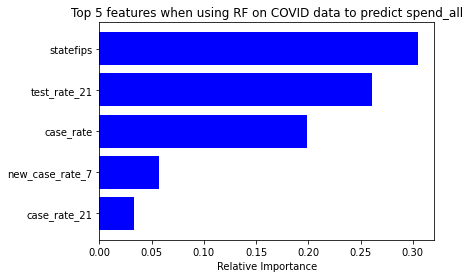

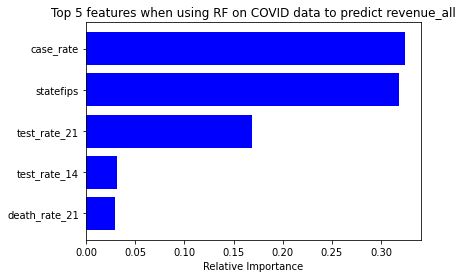

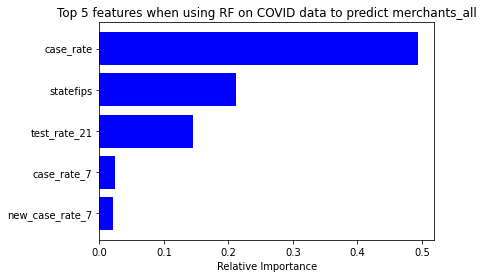

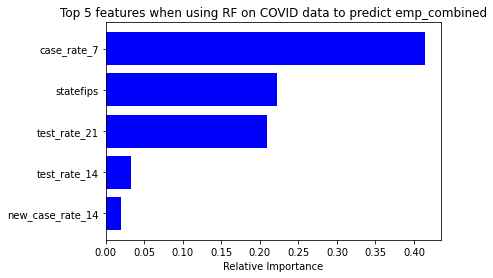

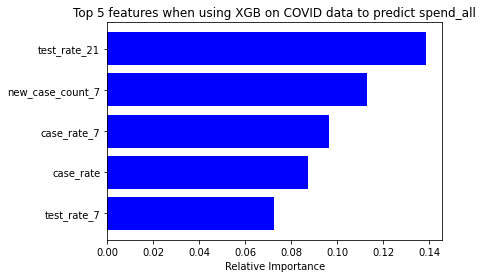

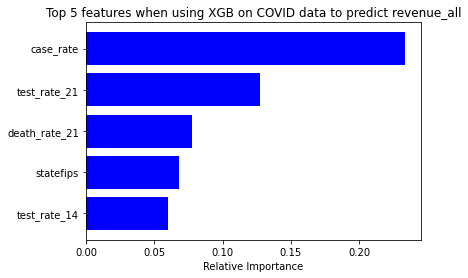

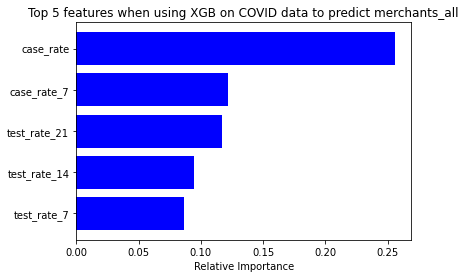

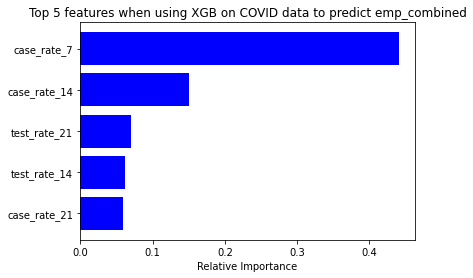

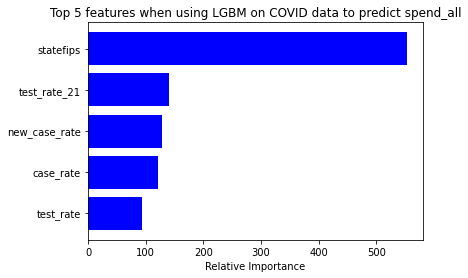

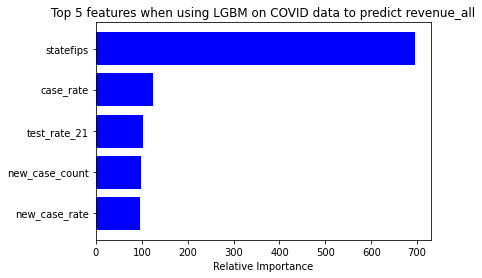

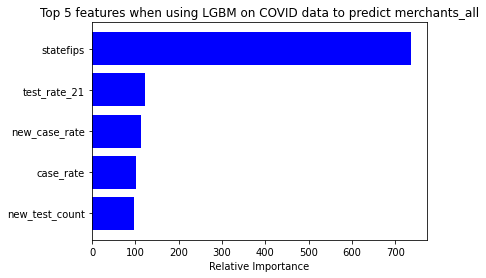

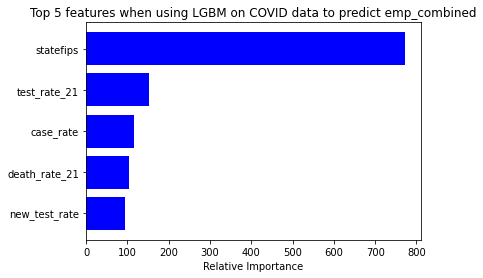

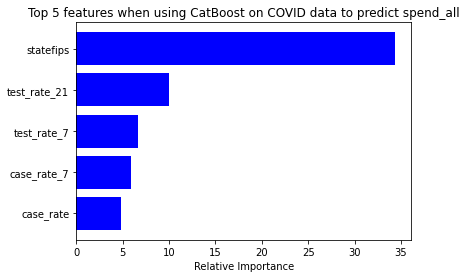

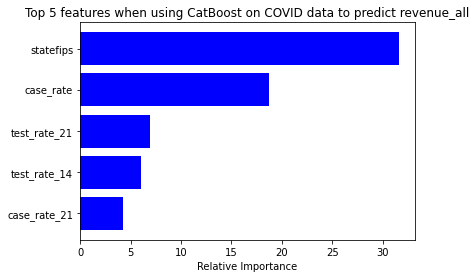

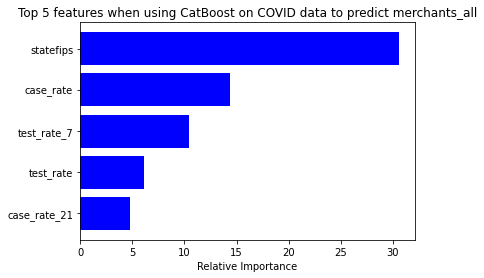

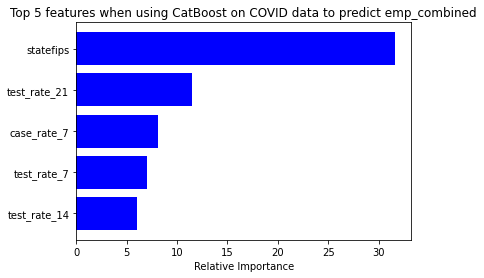

In [ ]:
models = [RandomForestRegressor(), xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
          LGBMRegressor(), CatBoostRegressor(verbose=False)]

model_names = ['RF','XGB','LGBM','CatBoost']

param_RF = {'n_estimators': [20],'max_depth' : [5,10,15] }

param_XGB = {}
param_Cat = {}
param_lgbm = {}
params = [param_RF, param_XGB, param_lgbm, param_Cat]

columns = ['spend_all','revenue_all','merchants_all','emp_combined']

for i in range(len(models)):

  for column in columns:
      if column != 'statefips':
        means = df_econ_new.loc[:'2020-07'].groupby('statefips')[column].mean()
        df_econ_encoded = df_econ_new.copy()
        temp = df_econ_encoded['statefips'].map(means)
        df_covid_encoded = df_covid_new.copy()
        df_covid_encoded['statefips'] = temp

        ## Preprocess the data using StandardScaler
        X_train = df_covid_encoded[:'2020-07']
        X_test = df_covid_encoded['2020-08-01':'2020-08-31']
        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

        y_train = df_econ_encoded.loc[:'2020-07', column]
        y_test = df_econ_encoded.loc['2020-8-01':'2020-08-31':, column]

        tscv = TimeSeriesSplit(n_splits=5)
        gsearch = GridSearchCV(estimator=models[i], cv=tscv, param_grid=params[i], scoring = 'r2')


        gsearch.fit(X_train, y_train)
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        
        features = list(df_covid_encoded.columns.values)

        importances_full = best_model.feature_importances_

        indices_full = np.argsort(importances_full)

        indices_full = indices_full[len(indices_full)-5:len(indices_full)]

        title = 'Top 5 features when using '+ model_names[i]+ ' on COVID data to predict '+ str(column)
        plt.title(title)
        plt.barh(range(len(indices_full)), importances_full[indices_full], color='b', align='center')
        plt.yticks(range(len(indices_full)), [features[i] for i in indices_full])
        plt.xlabel('Relative Importance')
        plt.show()
 

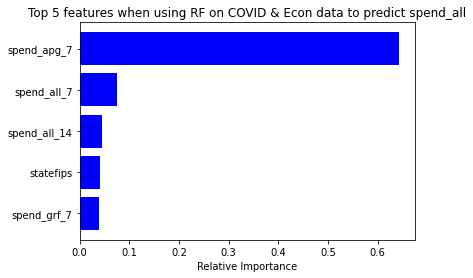

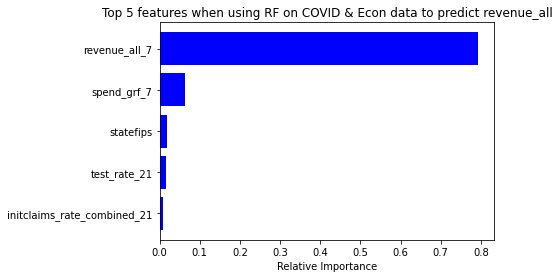

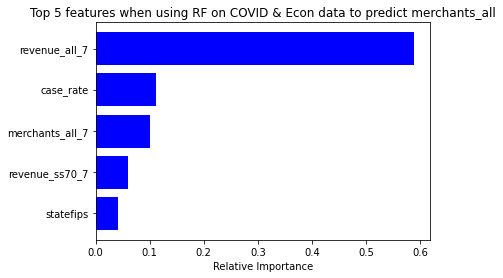

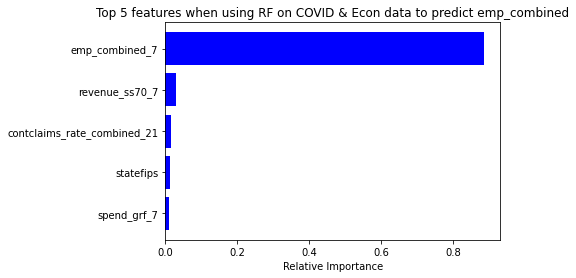

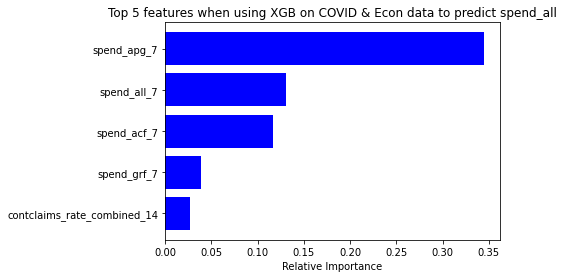

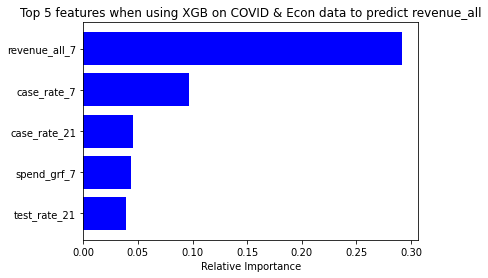

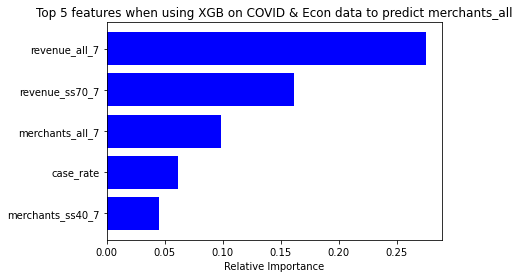

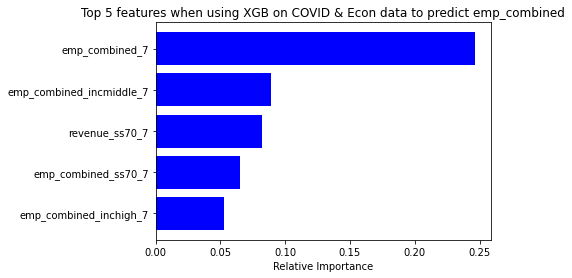

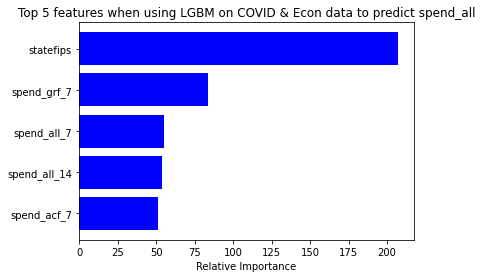

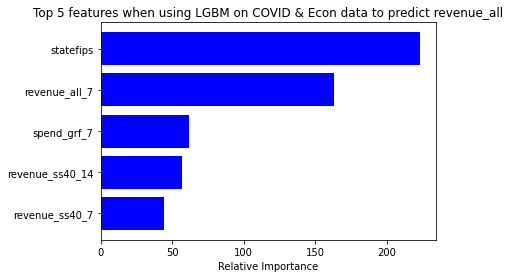

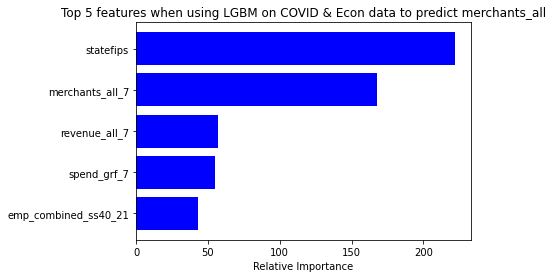

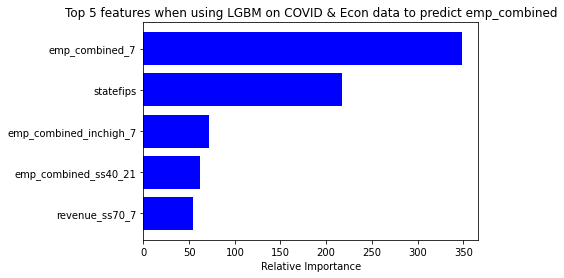

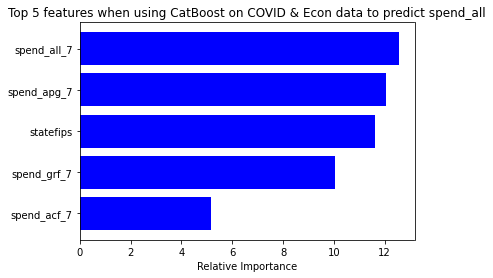

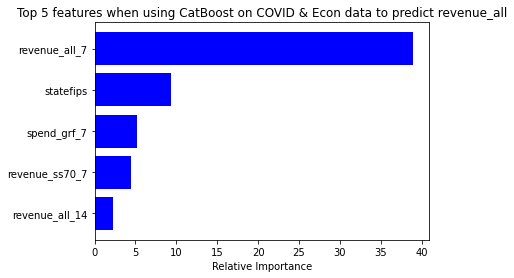

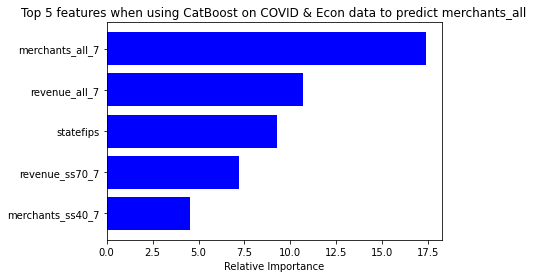

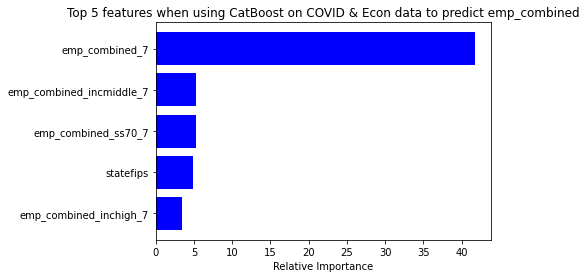

In [ ]:
models = [RandomForestRegressor(), xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
          LGBMRegressor(), CatBoostRegressor(verbose=False)]

model_names = ['RF','XGB','LGBM','CatBoost']

param_RF = {'n_estimators': [20],'max_depth' : [5,10,15] }

param_XGB = {}
param_Cat = {}
param_lgbm = {}
params = [param_RF, param_XGB, param_lgbm, param_Cat]

columns = ['spend_all','revenue_all','merchants_all','emp_combined']

for i in range(len(models)):

  for column in columns:
      if column != 'statefips':
        means = df_econ_new.loc[:'2020-07'].groupby('statefips')[column].mean()
        df_econ_encoded = df_econ_new.copy()
        temp = df_econ_encoded['statefips'].map(means)
        df_covid_encoded = df_covid_new.copy()
        df_covid_encoded['statefips'] = temp

        ## Preprocess the data using StandardScaler
        X_train = df_covid_encoded[:'2020-07']
        X_test = df_covid_encoded['2020-08-01':'2020-08-31']
        X_scaler = StandardScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)

        y_train = df_econ_encoded.loc[:'2020-07', column]
        y_test = df_econ_encoded.loc['2020-8-01':'2020-08-31':, column]

        tscv = TimeSeriesSplit(n_splits=5)
        gsearch = GridSearchCV(estimator=models[i], cv=tscv, param_grid=params[i], scoring = 'r2')


        gsearch.fit(X_train, y_train)
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        
        features = list(df_covid_encoded.columns.values)

        importances_full = best_model.feature_importances_

        indices_full = np.argsort(importances_full)

        indices_full = indices_full[len(indices_full)-5:len(indices_full)]

        title = 'Top 5 features when using '+ model_names[i]+ ' on COVID & Econ data to predict '+ str(column)
        plt.title(title)
        plt.barh(range(len(indices_full)), importances_full[indices_full], color='b', align='center')
        plt.yticks(range(len(indices_full)), [features[i] for i in indices_full])
        plt.xlabel('Relative Importance')
        plt.show()